In [1]:
import mido
import heapq # merge (i.e. from mergesort)
import ripser
import numpy as np
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange as trange
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.svm import SVC
import sklearn_tda as tda
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd

Gudhi not found--GraphInducedComplex not available


In [2]:
mid = mido.MidiFile('data/011.mid')
msgArray = []
for i, track in enumerate(mid.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:
        msgArray.append(msg)
#         print(msg)

Track 0: 
Track 1: 


In [3]:
# put together midi files 
def convertToAbsoluteTimeAndMerge(mid):
    # takes the full midi object as input
    # outputs list of pairs: [..., (abs_time, midi_message), ...]
    allEvents = []
    for i, track in enumerate(mid.tracks):
        allEvents.append([])
        abs_time = 0
        for msg in track:
            abs_time = abs_time + msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                allEvents[i].append((abs_time, msg))

    return list(heapq.merge(*allEvents, key=lambda x: x[0]))

In [4]:
# return one dimensional point cloud -> n nodes
def ExtractSingleNotesUnique(notes, getNote=lambda x: x):
    # takes the ordered set of notes as inputs. The actual note is accessed using the getNote function
    # outputs the set of notes (modulo 12) in the midi file
    noteSet = set()
    for note in notes:
        noteSet.add(getNote(note) % 12)
    return np.array(noteSet)

In [5]:
# 3D point cloud return -> note 1 note 2 note 3; note 2 note 3 note 4 -> easiest way to preserve time series. return M X N point cloud
def ExtractNotesTimeSeriesUnique(notes, N, getNote=lambda x: x):
    noteSeriesSet = set()
    for ind in range(len(notes) - N + 1):
        noteSeries = tuple(getNote(notes[ind + j]) % 12 for j in range(N))
        noteSeriesSet.add(noteSeries)
    return np.array([np.array(noteSeries) for noteSeries in noteSeriesSet])

In [6]:
# defines the distance function between every pair of points in the point cloud
def ComputeNNoteSeriesDistances(noteSeriesSet):
    dists = np.zeros((len(noteSeriesSet), len(noteSeriesSet)))
    for i in range(noteSeriesSet.shape[0]):
        for j in range(i, noteSeriesSet.shape[0]):
            v = np.abs(noteSeriesSet[i] - noteSeriesSet[j])
            diffVec = np.minimum(v, 12 - v)
            dists[i,j] = np.sum(diffVec)
            dists[j,i] = dists[i,j]
    return dists

In [7]:
mid = mido.MidiFile('data/013.mid')
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 1, getNote=lambda x: x[1].note)
print(len(notes))
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)
print(len(notes))
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 3, getNote=lambda x: x[1].note)
print(len(notes))

7
41
130


In [8]:
notes.shape

(130, 3)

In [9]:
notes[0]

array([8, 6, 6])

In [10]:
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)
print(len(notes))
notes[0].shape

41


(2,)

In [11]:
dists = ComputeNNoteSeriesDistances(notes)

In [12]:
print(notes[2])
print(notes[16])

[11 11]
[5 5]


In [13]:
dgms1 = ripser.ripser(dists, distance_matrix=True, maxdim=1)['dgms']
len(dgms1)

2

In [14]:
mid = mido.MidiFile('data/001.mid')

In [15]:
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)

In [16]:
dists = ComputeNNoteSeriesDistances(notes)

In [17]:
dgms2 = ripser.ripser(dists, distance_matrix=True, maxdim=1)['dgms']

In [18]:
def getDistances():
    numFiles = 100
    dim = 3
    bottleneck_distances = [np.zeros((numFiles, numFiles)) for x in range(dim+1)]
    wassertian_distances = [np.zeros((numFiles, numFiles)) for x in range(dim+1)]
    dgmArr = [[] for x in range(dim+1)]
    
    for i in trange(1, numFiles + 1):
        path = "data/{:03d}.mid".format(i)
        mid = mido.MidiFile(path)
        notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)
        dists = ComputeNNoteSeriesDistances(notes)
        dgms = ripser.ripser(dists, distance_matrix=True, maxdim=dim)['dgms']
        dgmArr[0].append(dgms[0][:-1])
        for j in range(1, dim+1):
            dgmArr[j].append(dgms[j])
            
    # Computing the distances between two dgmArr and plot it with TSNE
    for i in trange(numFiles):
        for j in (range(numFiles)):
            for k in range(dim+1):
                bottleneck_distances[k][i][j] = tda.bottleneck(dgmArr[k][i], dgmArr[k][j])
                
    # Computing the distances between two dgmArr and plot it with TSNE
    for i in trange(numFiles):
        for j in (range(numFiles)):
            for k in range(dim+1):
                wassertian_distances[k][i][j] = tda.wasserstein(dgmArr[k][i], dgmArr[k][j])
    
    return bottleneck_distances, wassertian_distances

In [19]:
## Compute the distances between the 0 and 1 dimensional persistence diagrams and plot it using TSNE

# Filling up the dgmArray for 0 and 1 dimension. 

numFiles = 100
dim = 3

bottleneck_distances = [np.zeros((numFiles, numFiles)) for x in range(dim+1)]
wassertian_distances = [np.zeros((numFiles, numFiles)) for x in range(dim+1)]
bottleneck_distances_dim0 = np.zeros((numFiles, numFiles))
bottleneck_distances_dim1 = np.zeros((numFiles, numFiles))
dgmArr = [[] for x in range(dim+1)]
dgmArr0 = []
dgmArr1 = []

In [20]:
for i in trange(1, numFiles + 1):
    path = "data/{:03d}.mid".format(i)
    mid = mido.MidiFile(path)
    notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)
    dists = ComputeNNoteSeriesDistances(notes)
    dgms = ripser.ripser(dists, distance_matrix=True, maxdim=dim)['dgms']
    dgmArr0.append(dgms[0][:-1])
    dgmArr1.append(dgms[1])   
    dgmArr[0].append(dgms[0][:-1])
    for j in range(1, dim+1):
        dgmArr[j].append(dgms[j])

In [21]:
songs_list = pd.read_csv('songs.csv')
np.unique(np.array(songs_list['Artist'], dtype='str'))

array(['Adele', 'Armin', 'Avicii', 'Backstreet boys', 'Beethoven',
       'Beyonce', 'Celine Dion', 'Chopin', 'Coldplay', 'Daft Punk',
       'Linkin Park', 'Michael Jackson', 'Owl City', 'Queen',
       'Red Hot Chilli Peppers', 'nan'], dtype='<U64')

In [22]:
# # Computing the distances between two dgmArr and plot it with TSNE
# for i in tqdm(range(numFiles)):
#     for j in (range(numFiles)):
#         bottleneck_distances_dim0[i][j] = tda.bottleneck(dgmArr0[i], dgmArr0[j])
#         bottleneck_distances_dim1[i][j] = tda.bottleneck(dgmArr1[i], dgmArr1[j])

In [23]:
# Computing the distances between two dgmArr and plot it with TSNE
for i in trange(numFiles):
    for j in (range(numFiles)):
        for k in range(dim+1):
            bottleneck_distances[k][i][j] = tda.bottleneck(dgmArr[k][i], dgmArr[k][j])

In [24]:
# Computing the distances between two dgmArr and plot it with TSNE
for i in trange(numFiles):
    for j in (range(numFiles)):
        for k in range(dim+1):
            wassertian_distances[k][i][j] = tda.wasserstein(dgmArr[k][i], dgmArr[k][j])

In [25]:
def computeDimReduction(method, distances):
    distances = (distances + distances.T)/2

    if method == 'MDS':
        embedding = MDS(n_components=2, dissimilarity='precomputed').fit_transform(distances)
    elif method == 'TSNE':
        embedding = TSNE(n_components=2, metric='precomputed').fit_transform(distances)
    return embedding

In [26]:
def plotScatter(points, title, labels):
    bd_x = points[:,0]
    bd_y = points[:,1]

    labels_uniq = np.unique(labels)
    
    # Define a colormap with the right number of colors
    cmap = plt.cm.get_cmap('tab20',len(labels_uniq))
    
    fig = plt.figure(figsize=(10,10))

    for i, label in enumerate(labels_uniq):
        plt.scatter(bd_x[labels==label], bd_y[labels==label], c=np.expand_dims(np.squeeze(cmap(i/len(labels_uniq))),0), label=label)

    plt.legend()
    plt.title(title)
    plt.show()

In [27]:
bottleneck_distances, wassertian_distances = getDistances()

0


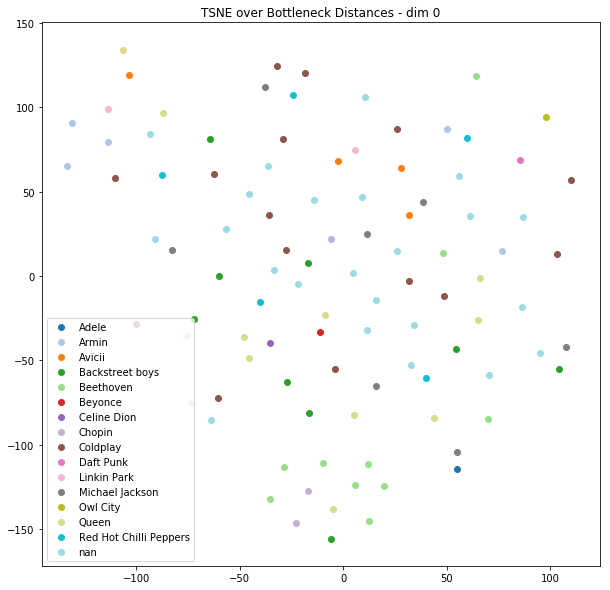

1


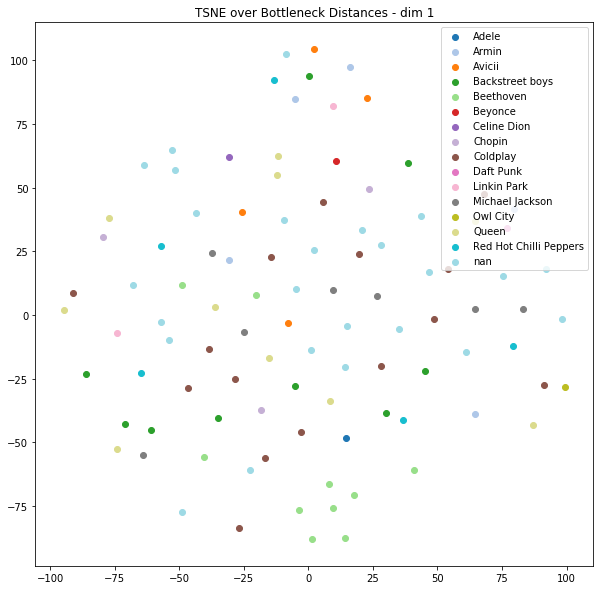

2


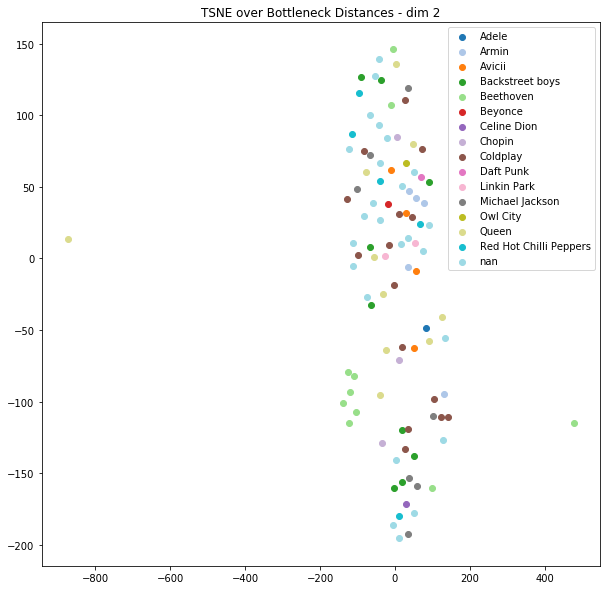

3


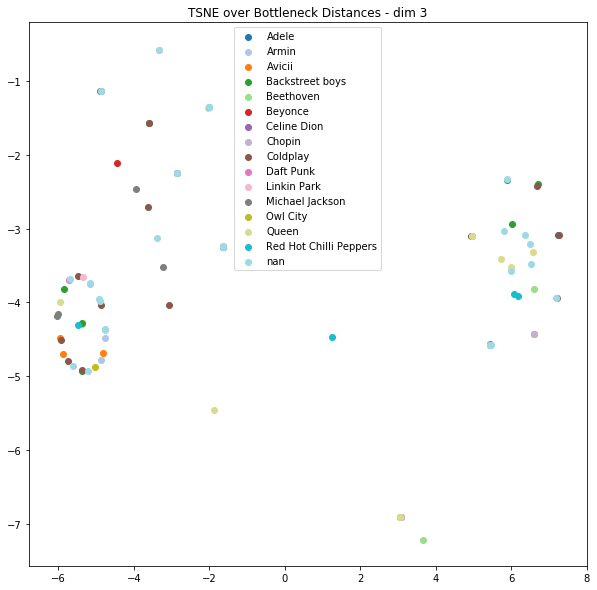

In [28]:
dim = 3

artists = np.array(songs_list['Artist'], dtype='str')

for j in range(dim+1):
    print(j)
    title = "TSNE over Bottleneck Distances - dim " + str(j)
    bottleneck_distances_TSNE = computeDimReduction('TSNE', bottleneck_distances[j])
    plotScatter(bottleneck_distances_TSNE, title, artists)

0


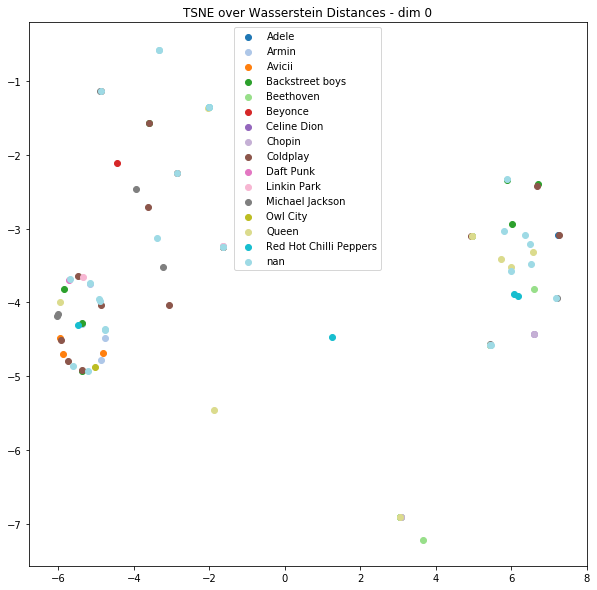

1


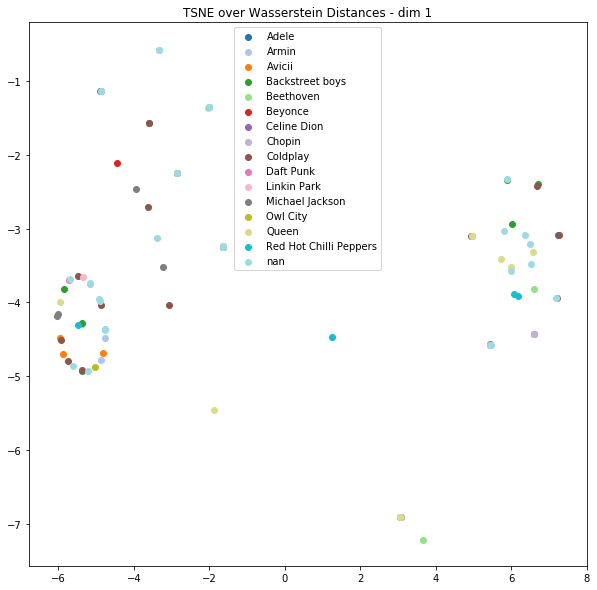

2


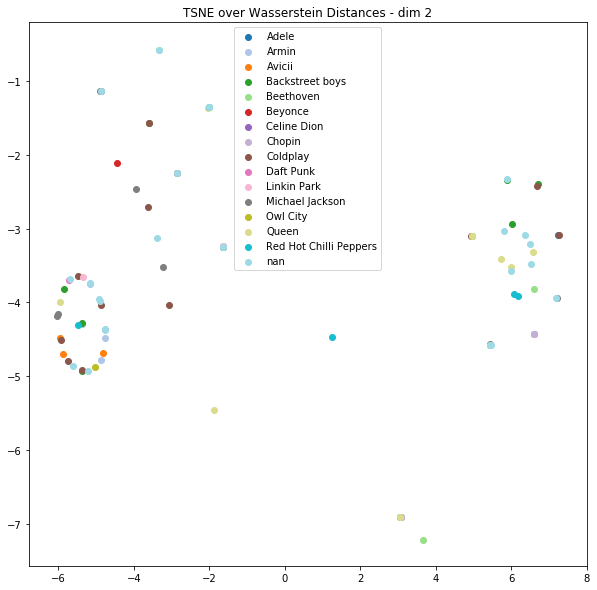

3


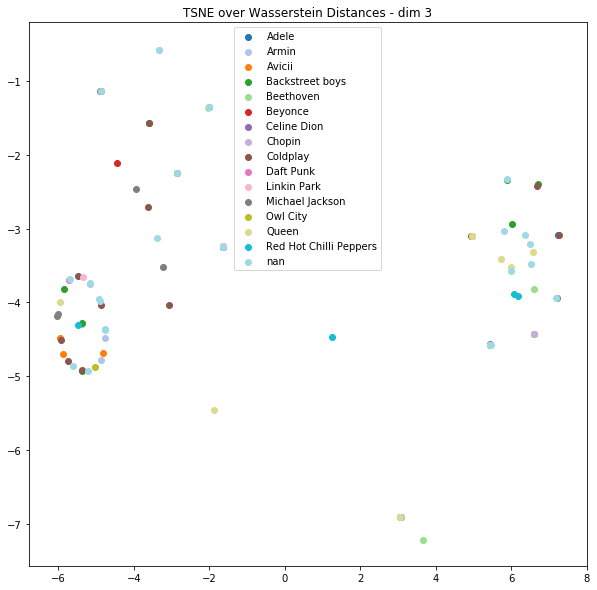

In [30]:
dim = 3
artists = np.array(songs_list['Artist'], dtype='str')
for j in range(dim+1):
    print(j)
    title = "TSNE over Wasserstein Distances - dim " + str(j)
    wassertian_distances_TSNE = computeDimReduction('TSNE', wassertian_distances[j])
    plotScatter(bottleneck_distances_TSNE, title, artists)

In [31]:
dim = 3
artists = np.array(songs_list['Artist'], dtype='str')
artists_uniq = np.unique(artists)

artists_labels = np.array([list(artists_uniq).index(artist) for artist in artists])

for j in range(dim+1):
    svc = SVC(kernel='precomputed')
    print(j)
    
    svc.fit(wassertian_distances[j][
        np.array(songs_list['Split'], dtype='str') == 'R'
    ][
        :,np.array(songs_list['Split'], dtype='str') == 'R'
    ], artists_labels[np.array(songs_list['Split'], dtype='str') == 'R'])

    y_gt = artists_labels[np.array(songs_list['Split'], dtype='str') == 'E']
    
    y_pred = svc.predict(
        wassertian_distances[j][
            np.array(songs_list['Split'], dtype='str') == 'E'
        ][
            :,np.array(songs_list['Split'], dtype='str') == 'R'
        ]
    )
    print(y_pred)
    print(y_gt)
    print('Accuracy of SVM with Wasserstein distances for dim {} features is {}'.format(j, np.sum(y_gt == y_pred) / len(y_gt)))

0
[4 4 4 4 4 4 4 4 3 4 8 2 2 4]
[13 13  8  8  8 14  3  3  7 11 11  4  4  2]
Accuracy of SVM with Wasserstein distances for dim 0 features is 0.0
1
[ 4  4  4  4  4  4  4  4 11  4  4 11 11  4]
[13 13  8  8  8 14  3  3  7 11 11  4  4  2]
Accuracy of SVM with Wasserstein distances for dim 1 features is 0.0
2
[ 4  4  4  4  8  4  4  4 11  4  4 11 11  4]
[13 13  8  8  8 14  3  3  7 11 11  4  4  2]
Accuracy of SVM with Wasserstein distances for dim 2 features is 0.07142857142857142
3
[13  8  4 13  8  2 13  4  8  2  4  8  8 13]
[13 13  8  8  8 14  3  3  7 11 11  4  4  2]
Accuracy of SVM with Wasserstein distances for dim 3 features is 0.14285714285714285


In [33]:
len(artists_uniq)

16